In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import ase.io as aio
import scipy.io as sio

import glob

from toolz.curried import pipe, curry

import numba
from numba import njit, jit
import atomistics as amks

import atom_stat as astat

you can install PyFFTW for speed-up as - 
conda install -c conda-forge pyfftw
you can install PyFFTW for speed-up as - 
conda install -c conda-forge pyfftw


In [3]:
try:
    import pyfftw
    np.fftpack = pyfftw.interfaces.numpy_fft
    pyfftw.interfaces.cache.enable()
except ImportError:
    print("you can install PyFFTW for speed-up as - ")
    print("conda install -c conda-forge pyfftw")
    pass

you can install PyFFTW for speed-up as - 
conda install -c conda-forge pyfftw


In [4]:
import matplotlib.pyplot as plt

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

def draw(im):
    plt.imshow(im)
    plt.colorbar()
    plt.show()

## Load the structure files and extract atomic coordinates

In [6]:
#For Standard Structures
# from ase.lattice.cubic import FaceCenteredCubic
# from ase.lattice.cubic import BodyCenteredCubic
# from ase.lattice.cubic import SimpleCubic
# from ase.lattice.hexagonal import HexagonalClosedPacked
# atom = FaceCenteredCubic(directions=[[0,0,1], [0,1,0], [-1,0,0]], size=(2,2,2), symbol='Cu', pbc=(1,1,1))
# atom = BodyCenteredCubic(directions=[[0,0,1], [0,1,0], [-1,0,0]], size=(10,10,10), symbol='Fe', pbc=(1,1,1))
# atom = SimpleCubic(directions=[[0,0,1], [0,1,0], [-1,0,0]], size=(12,12,12), symbol='Cu', pbc=(1,1,1), latticeconstant=1.0)
# atom = HexagonalClosedPacked(directions=[[0,0,0,1], [1,-1,0,0], [1,1,-2,0]], size=(8,8,8), symbol='Co', pbc=(1,1,1))
atom = aio.read("../data/input3dSlabs/MFI.cif")

rep = [2] * 3

atom    = atom.repeat(rep)
coords  = astat.get_coords(atom)[0]
pbc     = atom.get_pbc()
cell    = atom.get_cell()

print(coords.shape[0], "\ncell parameters\n", cell)

1536 
cell parameters
 [[40.18   0.     0.   ]
 [ 0.    39.476  0.   ]
 [ 0.     0.    26.284]]


In [7]:
r_stat = 6.0
len_pixel = 10

In [8]:
%%time
box0 = astat.get_voxelizedStats(coords, coords, r_stat=r_stat, len_pixel=len_pixel, cell=cell, pbc=pbc)

CPU times: user 1.22 s, sys: 184 ms, total: 1.4 s
Wall time: 920 ms


In [9]:
print(box0.shape)

(121, 121, 121)


## Visualize the statistics in X, Y and Z direction respectively 

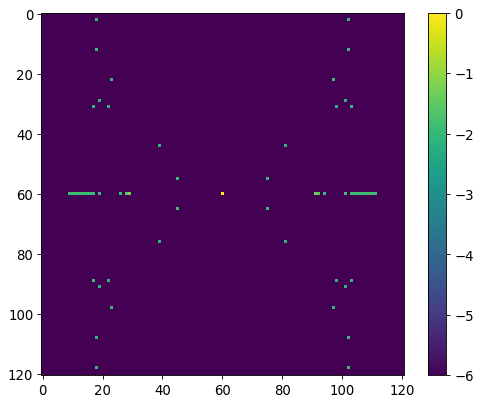

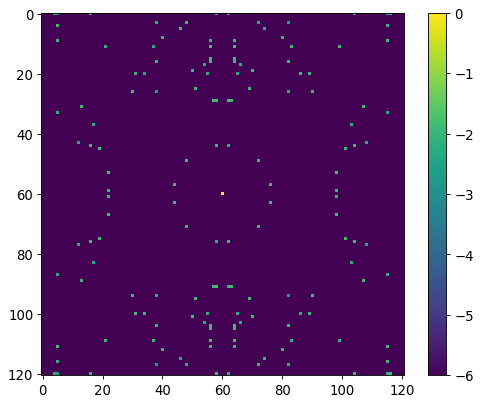

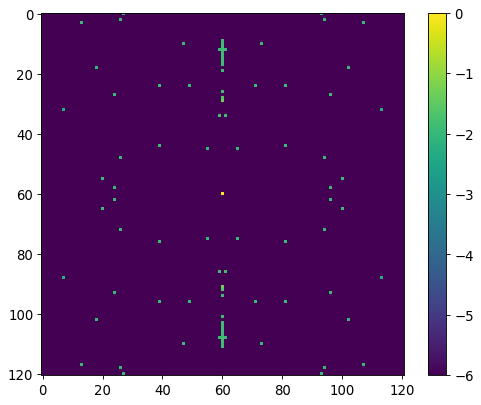

In [10]:
eps = 1e-6
idx = int(r_stat * len_pixel)
# draw(np.squeeze(box0[:,:,idx]))
# draw(np.squeeze(box0[:,idx,:]))
# draw(np.squeeze(box0[idx,:,:]))
draw(np.log10(np.squeeze((box0[:,:,idx]))+eps))
draw(np.log10(np.squeeze((box0[:,idx,:]))+eps))
draw(np.log10(np.squeeze((box0[idx,:,:]))+eps))

## Generate a smoothening filter of appropriate size to smoothen the above statistics

In [12]:
box_shape = box0.shape

r_s = 1.0
fshape = (np.asarray(box_shape) + np.round(2 * r_s * len_pixel)).astype(int)

sphere = astat.sphere(r_s * len_pixel)
vol = np.count_nonzero(sphere)
sphere = astat.padder(sphere, fshape)

fsphere = amks.imfilter(sphere, sphere) / vol

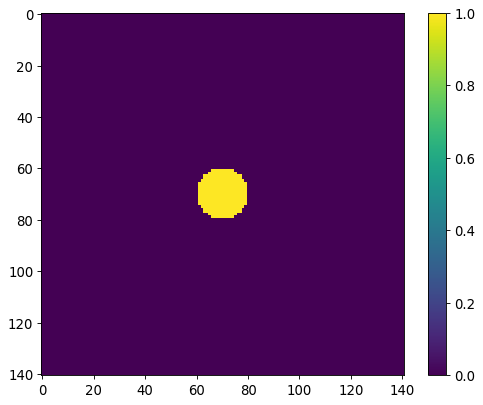

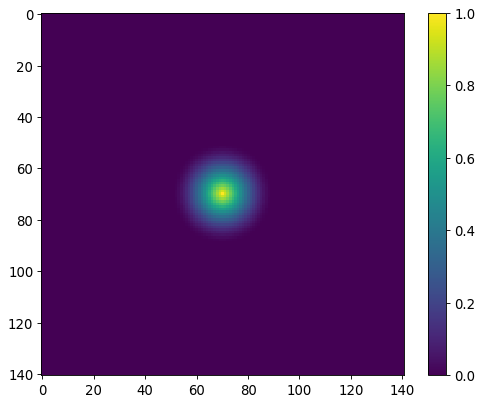

In [16]:
idx1 = fsphere.shape[0] // 2
draw((np.squeeze(sphere[:,idx1,:])))
draw((np.squeeze(fsphere[:,idx1,:])))

## Apply the filter to the voxelized, computed statistics

In [14]:
%%time
box1 = pipe(box0, 
            lambda x: amks.padder(x, fshape), 
            lambda x : amks.imfilter(x, fsphere))
print(box1.shape)

(141, 141, 141)
CPU times: user 555 ms, sys: 52.3 ms, total: 607 ms
Wall time: 306 ms


## Visualization of the smooth statistics

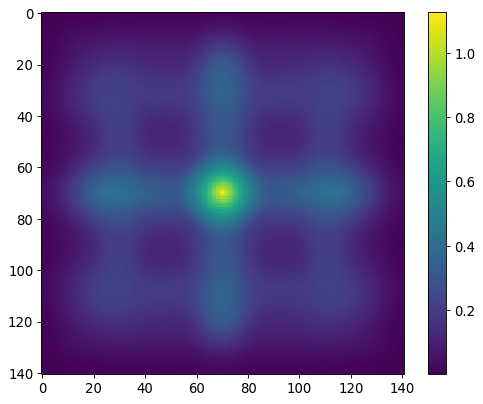

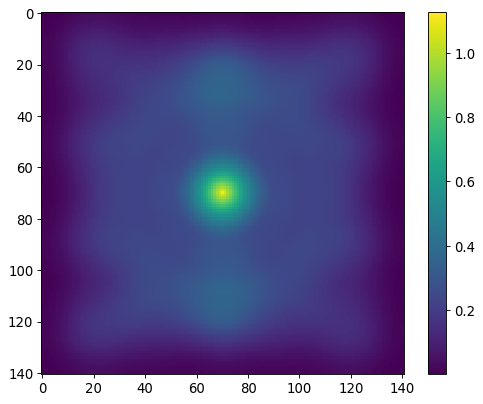

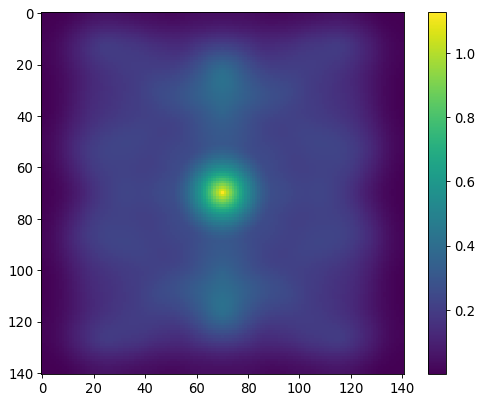

In [17]:
idx1 = box1.shape[0] // 2
draw(np.squeeze(box1[:,:,idx1]))
draw(np.squeeze(box1[:,idx1,:]))
draw(np.squeeze(box1[idx1,:,:]))

## How to convert a real space lattice to fractional space and then back?

Let's say, we have a particle at a position $\vec{\textbf r}$ and the lattice vectors, i.e. the vectors that form the sides of the simulation cell $\textbf a_i$. We can express $\textbf r$ in the basis of $\textbf a_i$:  
  
  
  $r = \sum_i f_i \textbf a_i$
  
You can express as a matrix-vector multiplication:  
  
  $\textbf r = \textbf{Af}$
  
where A is a matrix whose columns are the lattice vectors, and it can be seen that f are the fractional coordinates. So defining $\textbf A = \textbf B^{-1}$ one can find the fractional coordinates of $\textbf r$ simply by  
    
  $\textbf f = \textbf{Br}$
  
Now, if one wants all the images be be in the same cell, we can achieve this by ensuring $0 \leq f_i \leq 1$, and to achieve this we can simple modify $f_i$ to be $f_i - floor(f_i)$ and this simply translates particles to equivalent position in the reference cell under the assumption of periodic boundary conditions. So for arbitrary cell (in arbitrary dimensionality) the recipe is,

 - form $\textbf A$
 - invert $\textbf A$ to form $\textbf B$
 - From the position of a particle at $\textbf r$ get the fractional coordinates $\textbf f$ as $\textbf f = \textbf{Br}$
 - rescale fractional coordinates to fall within the reference cell as $g_i = f_i - floor(f_i)$
 - get the new position in real space $\textbf t$ as $\textbf t = \textbf{Ag}$